# Spatial Component Analysis Based on Latent Representations (SpaCO)

To investigate the spatial organization of latent features learned by the VAE-GAT model, a Spectral Component Analysis (SpaCO) approach was applied over the latent space. This method allows identification of directions in the latent space that align with the topology of a cell–cell similarity graph.

Step-by-step process:
1. Latent Feature Extraction: The matrix $μ ∈ ℝⁿˣᵈ$ was obtained by extracting the latent representations from the trained VAE-GAT model, where n is the number of cells and d is the latent dimensionality. This matrix μ captures nonlinear features learned from gene expression data and the graph structure.

2. Graph Construction and Laplacian Normalization: A k-nearest neighbors (k-NN) graph was built over the cells using their expression profiles. From this, an adjacency matrix $W ∈ ℝⁿˣⁿ$ was constructed where $W[i,j] = 1$ if cell j is a neighbor of cell i.
To model spatial dependencies, the symmetric normalized graph Laplacian L was computed using the formula:
$$L = D^{\frac{-1}{2}}WD^{\frac{-1}{2}}$$
where D is the degree matrix of the graph (diagonal matrix of node degrees). This normalization ensures scale invariance and improves the spectral analysis.

In [ ]:
#in this case mu: latnet tensor of the model (shape: n_cells × latent_dim)
# (2 × num_edges)
mu_np = mu.detach().cpu().numpy()
n_cells = mu_np.shape[0]


In [ ]:
# aDjacency matrix
rows, cols = edge_index_cells[0].numpy(), edge_index_cells[1].numpy()
data = np.ones(len(rows))
W = sp.coo_matrix((data, (rows, cols)), shape=(n_cells, n_cells)).tocsc()

In [ ]:
#Symetric normalized Laplacian L matrix
D = np.array(W.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(D + 1e-8))
L = D_inv_sqrt @ W.toarray() @ D_inv_sqrt

3. Computation of the Spatial Covariance Matrix $(μᵗLμ)$: The spatially-weighted covariance matrix was computed as:
$$𝑆=𝜇^{𝑇}𝐿𝜇$$


This matrix reflects the alignment of latent features with the graph structure. Each entry $S[i,j]$ measures how spatially correlated the ith and $jth$ latent features are.

4. Eigen-Decomposition of the Spatial Covariance Matrix: The matrix S was diagonalized through eigen-decomposition:
$$𝑆=𝑉Λ𝑉^{𝑇}$$

 
where Λ is a diagonal matrix of eigenvalues, and V contains the corresponding eigenvectors. In linear algebra, eigenvectors represent directions (or axes) in the feature space along which the data exhibit a specific mode of variation; eigenvalues quantify the amount of variance captured along each eigenvector.

These eigenvectors are referred to as SpaCO components (SpaCs) — analogous to principal components in PCA, but adapted to emphasize spatial coherence with the graph structure.

5. Projection onto SpaCO Components: The original latent matrix μ was projected onto the top-k SpaCO components for $k ∈ {1, ..., 30}$ using:
$$𝑍_𝑘=𝜇𝑉_𝑘$$


 
where $V_k$ contains the first k eigenvectors. This yields new feature matrices $Z_k ∈ ℝⁿˣᵏ$ representing cells in the reduced SpaC space.

In [ ]:
#  μᵗLμ and eigenvectors
spaco_matrix = mu_np.T @ L @ mu_np
eigvals, eigvecs = eigh(spaco_matrix)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

Clustering and Visualization: For each value of k, the following was performed:

- Neighborhood graph construction and UMAP embedding.
- Clustering via the Leiden algorithm (resolution = 0.5).
- Quantitative evaluation using the Silhouette Score (measuring intra/inter-cluster separation) and the Calinski–Harabasz Index (measuring compactness and separation).
- UMAP plots were generated to visualize the clustering results in 2D space.

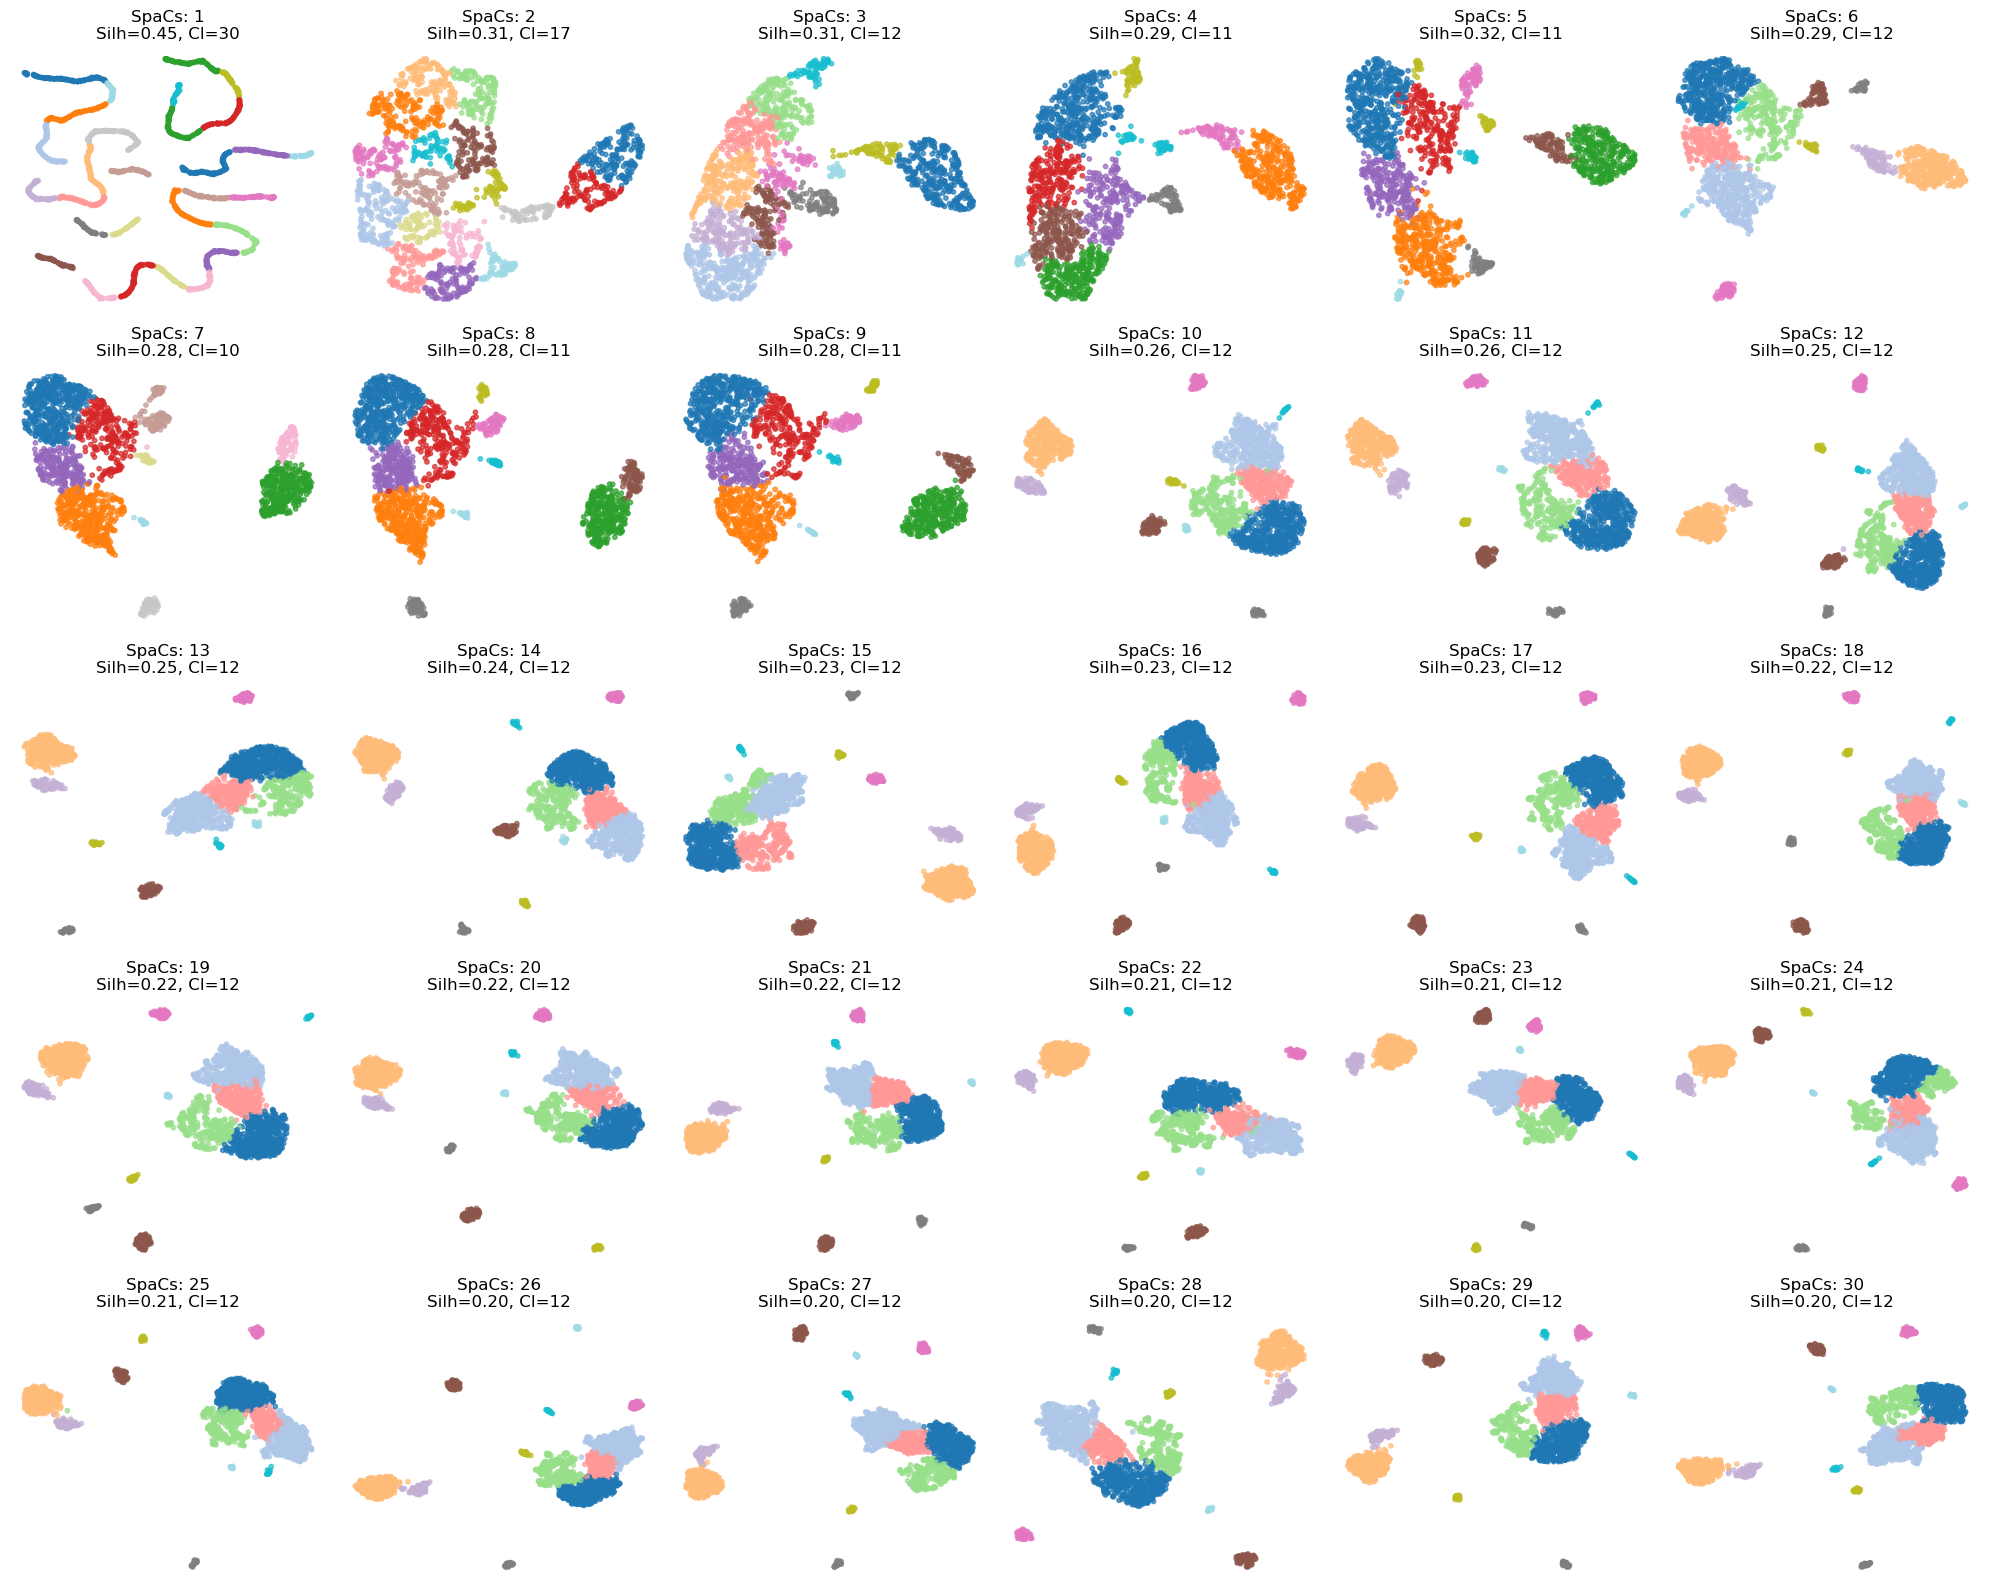

In [ ]:
results = []

# UMAP 
fig, axs = plt.subplots(5, 6, figsize=(20, 16))
axs = axs.flatten()

for k in range(1, 31):
    spaco_features = mu_np @ eigvecs[:, :k]  # Projection over SpaCs
    adata_spaco = sc.AnnData(X=spaco_features)
    sc.pp.neighbors(adata_spaco)
    sc.tl.umap(adata_spaco)
    sc.tl.leiden(adata_spaco, resolution=0.5)

    labels = adata_spaco.obs["leiden"].astype(int).to_numpy()
    umap_coords = adata_spaco.obsm["X_umap"]

    n_clusters = len(set(labels))
    silhouette = silhouette_score(spaco_features, labels) if n_clusters > 1 else -1
    calinski = calinski_harabasz_score(spaco_features, labels) if n_clusters > 1 else -1

    results.append({
        "k": k,
        "n_clusters": n_clusters,
        "silhouette": silhouette,
        "calinski": calinski
    })

    axs[k - 1].scatter(umap_coords[:, 0], umap_coords[:, 1], c=labels, cmap="tab20", s=10, alpha=0.7)
    axs[k - 1].set_title(f"SpaCs: {k}\nSilh={silhouette:.2f}, Cl={n_clusters}")
    axs[k - 1].axis("off")

plt.tight_layout()
plt.show()


Although projecting the latent space onto a single SpaCO component (k = 1) yielded the highest clustering metrics—achieving a Silhouette Score of 0.45 and a Calinski–Harabasz Index exceeding 12,900—this configuration produced 30 clusters, suggesting overfragmentation and limited interpretability. While the performance metrics were numerically optimal, relying on a single spatial component may oversimplify the underlying biological variability and overlook other spatially informative dimensions. In contrast, the projection onto the top five SpaCO components (k = 5) resulted in a more balanced outcome: 11 clusters with a respectable Silhouette Score of 0.316 and a Calinski Index of 1,350. This configuration captures richer spatial relationships while maintaining a manageable cluster granularity, making it more suitable for downstream biological interpretation. Therefore, although k = 1 defines an upper bound for clustering performance, k = 5 is considered the most practical and biologically meaningful choice in this context.

In [ ]:
results_df = pd.DataFrame(results)
results_df.head(20)

,k,n_clusters,silhouette,calinski
0,1,30,0.450049,12927.626244
1,2,17,0.312872,3257.066478
2,3,12,0.310966,1995.034782
3,4,11,0.293294,1584.206177
4,5,11,0.316865,1350.552981
5,6,12,0.292928,1104.428820
6,7,10,0.276201,1163.911760
7,8,11,0.280297,1018.565714
8,9,11,0.275027,947.401387
9,10,12,0.261968,811.374206


#### Variances

To assess the extent to which the learned latent representations capture spatially coherent structures, a variance decomposition analysis was performed. This approach aimed to separate the total variability in the latent space into two components: global variance and spatially structured variance, the latter being aligned with the topology of the cell–cell graph. The global variance quantifies the total spread or variability in the latent space, independent of any neighborhood relationships. In contrast, the spatial variance captures the portion of this variability that is consistent with the local structure encoded in the cell–cell graph. This graph represents biological proximity or similarity between cells and is typically constructed based on gene expression or spatial coordinates. By computing the fraction of the total variance that is spatially structured, it becomes possible to evaluate how much of the latent signal is influenced by the local graph topology. This ratio serves as an indicator of spatial alignment in the latent embedding, revealing whether the model has learned features that reflect biologically meaningful organization across the graph. A high spatial fraction suggests that the latent space encodes localized patterns, while a lower fraction would imply more global or unstructured variability.

In [84]:
spaco_matrix = mu_np.T @ L @ mu_np

In [85]:
var_global = np.trace(mu_np.T @ mu_np)


In [86]:
# Spatial (graph-weighted) variance
var_spatial = np.trace(mu_np.T @ L @ mu_np)

# Proportion of variance explained by spatial structure
spatial_fraction = var_spatial / var_global

**Global Variance** refers to the sum of the variances across all dimensions of the latent space μ. It indicates the overall diversity among the cells in that space.
The global variance, calculated as 969,838, reflects the total spread of the latent representations across all dimensions of the embedding space. This value is relatively high, indicating that the model has captured a broad range of variability among the input cells. Such a scale suggests that the latent space is rich in structure and effectively separates diverse cell states or types. In practical terms, a high global variance often implies that the encoder of the VAE+GAT model is preserving significant biological or structural heterogeneity

```{admonition} Spatially-Structured Variance
Computed as: trace(μᵗ L μ)
This value reflects the extent to which the variability in the latent space is organized in a way that is consistent with the cell–cell graph structure.
In other words, it measures whether the differences in the embedding align with the graph topology (i.e., neighborhood relationships).
```

In this case: 184,416, indicating that a significant portion of the variation is aligned with the graph.

In [87]:
print(f"Global variance: {var_global:.4f}")
print(f"Spatial (graph-aware) variance: {var_spatial:.4f}")
print(f"Fraction of spatially-structured variance: {spatial_fraction:.4f}")

Global variance: 969838.9375
Spatial (graph-aware) variance: 184416.0143
Fraction of spatially-structured variance: 0.1902


```{admonition} Spatially-Structured Fraction (~0.19)
This means that approximately 19% of the variance in the latent space exhibits a topological structure—i.e., it is "localized" on the graph.

In other words, about 19% of the latent signal is correlated with the connectivity of the cell–cell graph.
```

How to interpret the 0.19 value?

This is not a low value. In single-cell data—especially when not derived from spatial technologies (such as Visium or MERFISH)—it is common for only a small fraction of the variance to be spatially organized. This suggests that the VAE-GAT embedding has captured structure that respects the graph of neighboring cells, at least partially.

- The cell–cell graph is contributing meaningful information to the model.
- The embedding is not random with respect to the graph.

In [ ]:
eigvals, eigvecs = eigh(mu_np.T @ L @ mu_np)
eigvals = eigvals[np.argsort(eigvals)[::-1]]  # sort descending

# Normalize by global variance to get relative contribution
eigvals_relative = eigvals / var_global

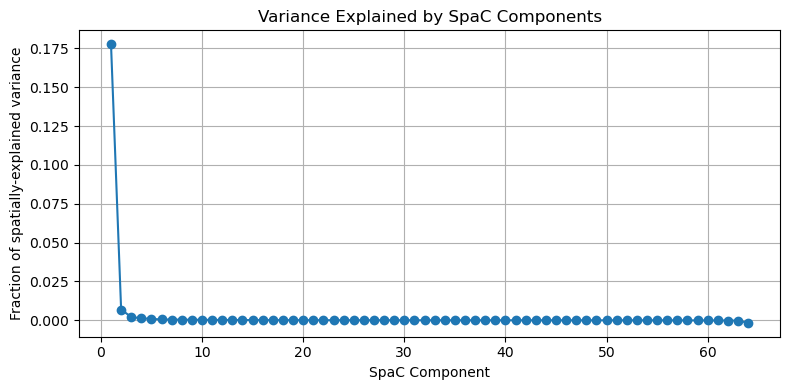

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(eigvals) + 1), eigvals_relative, marker='o')
plt.xlabel("SpaC Component")
plt.ylabel("Fraction of spatially-explained variance")
plt.title("Variance Explained by SpaC Components")
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusion

The selection of Leiden resolution 0.8 for the VAE + GAT model in the clustering benchmark was guided by a comprehensive evaluation of multiple clustering metrics, each reflecting complementary aspects of performance. The Leiden algorithm, known for its robustness in community detection in graph-based representations, was applied at various resolution levels to explore how fine-grained or coarse the clustering results could become. Among these, the resolution of 0.8 emerged as the most effective, especially when paired with the VAE + GAT model, a combination that integrates both latent representation learning and graph attention mechanisms for enhanced spatial awareness in single-cell RNA sequencing data.

Specifically, at resolution 0.8, the VAE + GAT model achieved the highest Silhouette Score (0.47195) across all configurations, indicating strong intra-cluster cohesion and inter-cluster separation. This metric is especially meaningful in evaluating the compactness and distinguishability of clusters in the latent space. Furthermore, the Calinski-Harabasz Index at this resolution also peaked, reaching 2774.32, which quantifies the ratio of between-cluster dispersion to within-cluster dispersion—a hallmark of well-formed clusters. Additionally, the Mean Squared Error (MSE) and Pearson correlation between the original and reconstructed data at this resolution provided further evidence of high reconstruction fidelity and strong global structure preservation in the learned latent representations.

``Benchmark Metrics Table (Leiden Resolution 0.8 – VAE + GAT)``

| Metric                    | Value       | Method | Resolution |
|--------------------------|-------------|--------|------------|
| Silhouette Score         | 0.471954    | Leiden | 0.8        |
| Calinski-Harabasz Index  | 2774.322012 | Leiden | 0.8        |
| Mean Squared Error (MSE) | 0.012455    | Leiden | 0.8        |
| Pearson Correlation      | 0.0926571    | Leiden | 0.8        |
|Latent Space Normality (p-value)|0.000477|Leidein | 0.8 |